In [12]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks

In [13]:
# Load the file
data_file = Path("../Data/3kn-0.5.xlsx") # Change this to the appropriate folder/file
df = pl.read_excel(source=data_file, sheet_name="Analog")

In [14]:
offset = 0
sampling_speed = 1000
speed = 0.5
data_point_length = speed / sampling_speed

In [15]:
data_point_length

0.0005

In [16]:
header_names = df.columns
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
df = df.with_columns(
    x_data,
    ((16+pl.col("Voltage")) * 1000 - offset).alias("Left Gap [\u03bcm]"),
    ((16+((pl.col("Dev1/ai3")/250*1000)-4)*(10/16))*1000-offset).alias("Right Gap [\u03bcm]"),
    (pl.col("Dev1/ai2")*112.3898+558.30904-offset).alias("Load [N]")
)

In [17]:
# plt.plot(x, left_gap)
# plt.ylim(-200, 100)
# plt.xlim(-40, 140)

# index = np.where(x>-25)[0][0]
# print(index)

In [18]:
## Finding the offset points for data collection
load_offset = np.mean(df.select("Load [N]").head(100).to_numpy())

# Extract data for plotting
x = df["Axial Distance [mm]"] 
left_gap = df["Left Gap [\u03bcm]"]
right_gap = df["Right Gap [\u03bcm]"]
load = df["Load [N]"]

load = load - load_offset

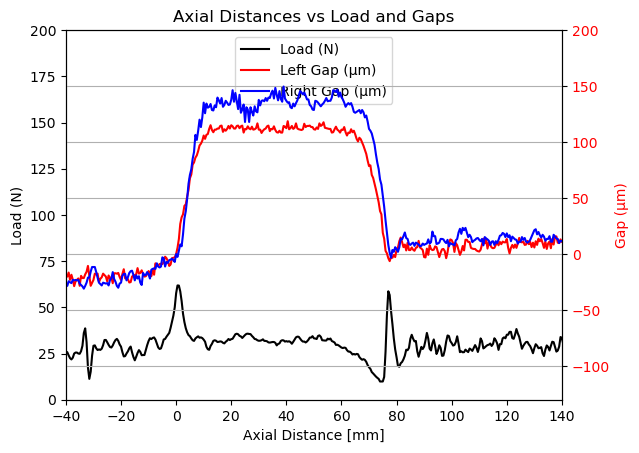

In [19]:

## 0 point around 13950

lubrication_point = 13950

left_gap = left_gap - left_gap[lubrication_point]
right_gap = right_gap - right_gap[lubrication_point]
x = x - x[lubrication_point]

## Plot the data
# Load plot
fig, ax1 = plt.subplots()

load_plot = ax1.plot(x, load, color='black', label="Load (N)")
ax1.set_xlabel("Axial Distance [mm]")
ax1.set_ylabel("Load (N)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 200)

# Gap plots
ax2 = ax1.twinx() # Have the same x axis

left_gap_plot = ax2.plot(x, left_gap, color='red', label="Left Gap (μm)")
right_gap_plot = ax2.plot(x, right_gap, color='blue', label="Right Gap (μm)")
ax2.set_ylabel("Gap (μm)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# COmbinte the legends and output it
lines= load_plot + left_gap_plot + right_gap_plot
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper center")

plt.xlim(-40, 140)
plt.ylim(-130,200)
plt.title("Axial Distances vs Load and Gaps")
plt.grid()
plt.show()

In [20]:
left_gap

Left Gap [μm]
f64
-8086.51125
-8084.538314
-8080.921265
-8085.853605
-8087.826541
…
-8084.209492
-8087.168895
-8078.619507


In [21]:
left_gap = df["Left Gap [μm]"].to_numpy()
peaks, _ = find_peaks(left_gap)

peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

bound = 200 ## TODO: ADD this onto the top variable which can be changed later
start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound # Take the bound away from the file

## refining data points now
left_gap = left_gap[start_index:end_index]
offset_pos = start_index
end_pos = end_index

peaks, _ = find_peaks(left_gap)
peak = sorted(peaks, key = lambda x : left_gap[x], reverse=True)[0]
start_index, end_index = peak - bound, peak + bound # The area we want to analyze
left_gap = left_gap[start_index:end_index]
offset_pos += start_index
end_pos = end_index

x_range = 400
load = df["Load [N]"][offset_pos:offset_pos+x_range].to_numpy()
left_gap = df["Left Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
right_gap = df["Right Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
x = df["Axial Distance [mm]"][offset_pos:offset_pos+x_range].to_numpy()


load_peaks, _ = find_peaks(load)
zero_pos = sorted(load_peaks, key = lambda x : load[x], reverse=True)[0]

left_gap = left_gap - left_gap[zero_pos]
right_gap = right_gap - right_gap[zero_pos]
x = x - x[zero_pos]

load_offset = np.mean(df.select("Load [N]").head(100).to_numpy())
load = load - load_offset 

Steady portion found from index 153 to 239
Average Value: 106.79


C:\Users\gyang\AppData\Local\Temp\ipykernel_11504\722026584.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')


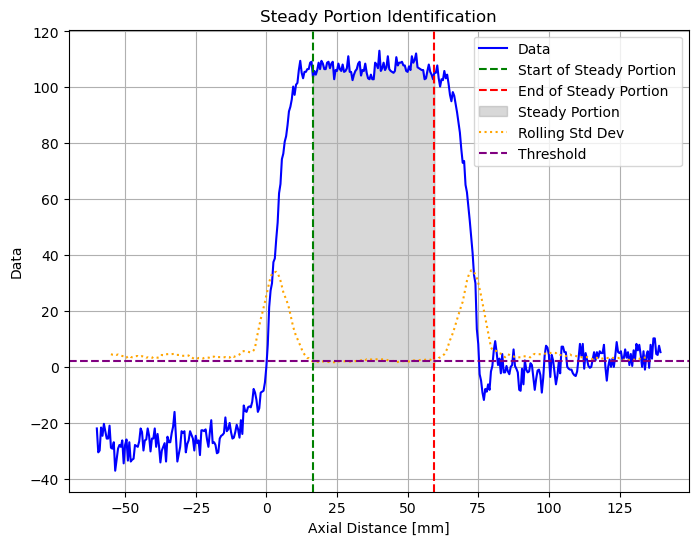

In [22]:
def find_steady_portion(axial_distance, data, window_size=10, threshold=2):
    """
    Finds the steady portion of the data and calculates the average for that section.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze (e.g., left_gap, load, etc.).
        window_size (int): Window size for calculating the rolling standard deviation.
        threshold (float): Threshold for identifying the steady portion based on standard deviation.

    Returns:
        tuple: (start_index, end_index, average_value, steady_axial_distance, steady_data)

    Example:
        >>> start_idx, end_idx, avg, x_steady, data_steady = find_steady_portion(x, data)
    """
    # Step 1: Calculate rolling standard deviation
    rolling_std = pd.Series(data).rolling(window=window_size, center=True).std()

    # Handle NaN in rolling_std by forward/backward filling
    rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')

    # Step 2: Identify steady-state range using the threshold
    steady_indices = rolling_std[rolling_std < threshold].index

    # Step 3: Find the start and end of the steady portion
    if len(steady_indices) > 0:
        start_idx = steady_indices[0]
        end_idx = steady_indices[-1]

        # Step 4: Filter data within this range
        steady_axial_distance = axial_distance[start_idx:end_idx+1]
        steady_data = data[start_idx:end_idx+1]

        # Compute averages
        average_value = np.mean(steady_data)
        return start_idx, end_idx, average_value, steady_axial_distance, steady_data
    else:
        print("No steady portion found with the given threshold.")
        return None, None, None, None, None

# Example usage
# Replace these with your actual data
axial_distance = x  # Example axial distance data

# Call the function
start_idx, end_idx, avg_value, steady_axial, steady_data = find_steady_portion(axial_distance, left_gap, window_size=20, threshold=2)

if start_idx is not None:
    print(f"Steady portion found from index {start_idx} to {end_idx}")
    print(f"Average Value: {avg_value:.2f}")

    # Plot the original data
    plt.figure(figsize=(8, 6))
    plt.plot(axial_distance, left_gap, label="Data", color='blue')
    plt.axvline(axial_distance[start_idx], color='green', linestyle='--', label="Start of Steady Portion")
    plt.axvline(axial_distance[end_idx], color='red', linestyle='--', label="End of Steady Portion")
    plt.fill_between(axial_distance[start_idx:end_idx+1], 
                     left_gap[start_idx:end_idx+1], 
                     alpha=0.3, color='gray', label="Steady Portion")
    
    # Overlay rolling standard deviation
    rolling_std = pd.Series(left_gap).rolling(window=20, center=True).std()
    plt.plot(axial_distance, rolling_std, color='orange', linestyle=':', label="Rolling Std Dev")
    plt.axhline(y=2, color='purple', linestyle='--', label="Threshold")
    
    plt.xlabel("Axial Distance [mm]")
    plt.ylabel("Data")
    plt.title("Steady Portion Identification")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No steady portion was identified. Adjust the threshold or window size.")

Rising Edge Index: 115, Lowering Edge Index: 274
Steady Portion: 116 to 273
Steady Average Value: 89.82


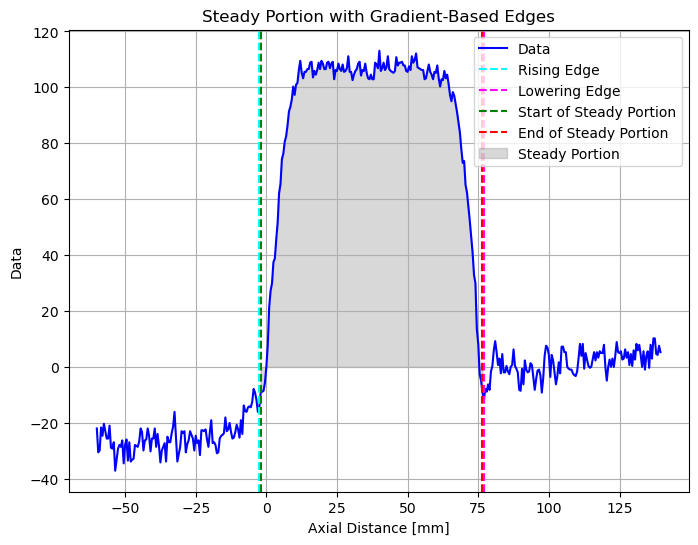

In [23]:
from scipy.signal import savgol_filter

def find_steady_portion_with_gradient(axial_distance, data, window_size=10, polyorder=2, gradient_threshold=10):
    """
    Finds the steady portion using gradient analysis and Savitzky-Golay smoothing.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze.
        window_size (int): Window size for smoothing.
        polyorder (int): Polynomial order for Savitzky-Golay filter.
        gradient_threshold (float): Threshold for identifying edges based on gradient.

    Returns:
        dict: Dictionary with edge indices, steady portion indices, and steady average.
    """
    # Step 1: Smooth the data using Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_size, polyorder=polyorder)

    # Step 2: Calculate the gradient of the smoothed data
    gradient = np.gradient(smoothed_data, axial_distance)

    # Step 3: Identify rising and lowering edges using gradient thresholds
    rising_edge_idx = np.where(gradient > gradient_threshold)[0][0]  # First large positive slope
    lowering_edge_idx = np.where(gradient < -gradient_threshold)[0][-1]  # Last large negative slope

    # Step 4: Define the steady portion as the region between edges
    steady_start_idx = rising_edge_idx + 1  # Start after the rising edge
    steady_end_idx = lowering_edge_idx - 1  # End before the lowering edge

    if steady_start_idx < steady_end_idx:
        # Filter steady portion
        steady_axial = axial_distance[steady_start_idx:steady_end_idx + 1]
        steady_data = data[steady_start_idx:steady_end_idx + 1]
        steady_average = np.mean(steady_data)

        return {
            "rising_edge_idx": rising_edge_idx,
            "lowering_edge_idx": lowering_edge_idx,
            "steady_start_idx": steady_start_idx,
            "steady_end_idx": steady_end_idx,
            "steady_average": steady_average,
            "steady_axial": steady_axial,
            "steady_data": steady_data,
        }
    else:
        print("No valid steady portion found.")
        return None


# Example usage
result = find_steady_portion_with_gradient(axial_distance, left_gap, window_size=21, polyorder=2, gradient_threshold=3)

if result:
    print(f"Rising Edge Index: {result['rising_edge_idx']}, Lowering Edge Index: {result['lowering_edge_idx']}")
    print(f"Steady Portion: {result['steady_start_idx']} to {result['steady_end_idx']}")
    print(f"Steady Average Value: {result['steady_average']:.2f}")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(axial_distance, left_gap, label="Data", color='blue')
    plt.axvline(axial_distance[result['rising_edge_idx']], color='cyan', linestyle='--', label="Rising Edge")
    plt.axvline(axial_distance[result['lowering_edge_idx']], color='magenta', linestyle='--', label="Lowering Edge")
    plt.axvline(axial_distance[result['steady_start_idx']], color='green', linestyle='--', label="Start of Steady Portion")
    plt.axvline(axial_distance[result['steady_end_idx']], color='red', linestyle='--', label="End of Steady Portion")
    plt.fill_between(axial_distance[result['steady_start_idx']:result['steady_end_idx'] + 1],
                     left_gap[result['steady_start_idx']:result['steady_end_idx'] + 1],
                     alpha=0.3, color='gray', label="Steady Portion")
    plt.xlabel("Axial Distance [mm]")
    plt.ylabel("Data")
    plt.title("Steady Portion with Gradient-Based Edges")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Adjust parameters to detect the steady portion.")

Refined Rising Edge Index: 116, Refined Lowering Edge Index: 273
Steady Portion: 117 to 272
Steady Average Value: 91.09


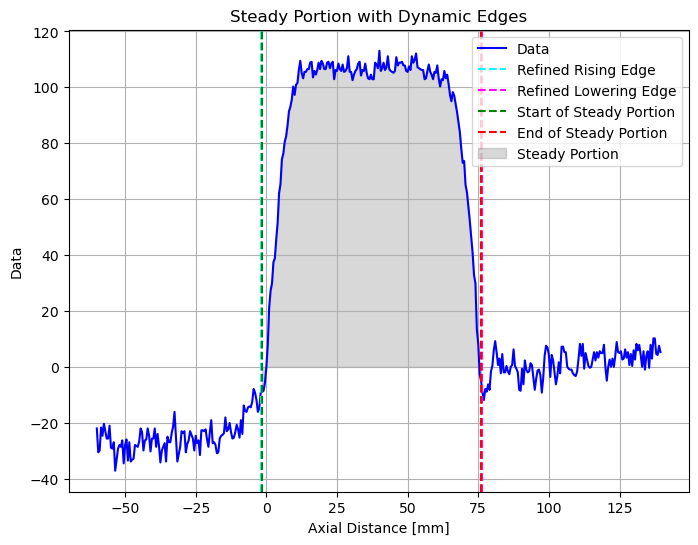

In [24]:
def find_steady_portion_dynamically(axial_distance, data, window_size=10, polyorder=2, gradient_threshold=10):
    """
    Dynamically finds the steady portion and adjusts edges based on data trends.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze.
        window_size (int): Window size for smoothing.
        polyorder (int): Polynomial order for Savitzky-Golay filter.
        gradient_threshold (float): Threshold for identifying edges based on gradient.

    Returns:
        dict: Dictionary with edge indices, steady portion indices, and steady average.
    """
    # Step 1: Smooth the data using Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_size, polyorder=polyorder)

    # Step 2: Calculate the gradient of the smoothed data
    gradient = np.gradient(smoothed_data, axial_distance)

    # Step 3: Detect approximate rising and lowering edges
    rising_edge_idx = np.where(gradient > gradient_threshold)[0][0]
    lowering_edge_idx = np.where(gradient < -gradient_threshold)[0][-1]

    # Step 4: Refine edges to the nearest local minima dynamically
    # Refine rising edge: Find the lowest point before the rising edge
    rising_candidates = np.where(np.gradient(smoothed_data[:rising_edge_idx]) > 0)[0]
    refined_rising_edge_idx = rising_candidates[-1] if len(rising_candidates) > 0 else rising_edge_idx

    # Refine lowering edge: Find the lowest point after the lowering edge
    lowering_candidates = np.where(np.gradient(smoothed_data[lowering_edge_idx:]) < 0)[0]
    refined_lowering_edge_idx = lowering_edge_idx + lowering_candidates[0] if len(lowering_candidates) > 0 else lowering_edge_idx

    # Define the steady portion
    steady_start_idx = refined_rising_edge_idx + 1
    steady_end_idx = refined_lowering_edge_idx - 1

    if steady_start_idx < steady_end_idx:
        # Filter steady portion
        steady_axial = axial_distance[steady_start_idx:steady_end_idx + 1]
        steady_data = data[steady_start_idx:steady_end_idx + 1]
        steady_average = np.mean(steady_data)

        return {
            "rising_edge_idx": refined_rising_edge_idx,
            "lowering_edge_idx": refined_lowering_edge_idx,
            "steady_start_idx": steady_start_idx,
            "steady_end_idx": steady_end_idx,
            "steady_average": steady_average,
            "steady_axial": steady_axial,
            "steady_data": steady_data,
        }
    else:
        print("No valid steady portion found.")
        return None


# Example usage
result = find_steady_portion_dynamically(axial_distance, left_gap, window_size=21, polyorder=2, gradient_threshold=5)

if result:
    print(f"Refined Rising Edge Index: {result['rising_edge_idx']}, Refined Lowering Edge Index: {result['lowering_edge_idx']}")
    print(f"Steady Portion: {result['steady_start_idx']} to {result['steady_end_idx']}")
    print(f"Steady Average Value: {result['steady_average']:.2f}")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(axial_distance, left_gap, label="Data", color='blue')
    plt.axvline(axial_distance[result['rising_edge_idx']], color='cyan', linestyle='--', label="Refined Rising Edge")
    plt.axvline(axial_distance[result['lowering_edge_idx']], color='magenta', linestyle='--', label="Refined Lowering Edge")
    plt.axvline(axial_distance[result['steady_start_idx']], color='green', linestyle='--', label="Start of Steady Portion")
    plt.axvline(axial_distance[result['steady_end_idx']], color='red', linestyle='--', label="End of Steady Portion")
    plt.fill_between(axial_distance[result['steady_start_idx']:result['steady_end_idx'] + 1],
                     left_gap[result['steady_start_idx']:result['steady_end_idx'] + 1],
                     alpha=0.3, color='gray', label="Steady Portion")
    plt.xlabel("Axial Distance [mm]")
    plt.ylabel("Data")
    plt.title("Steady Portion with Dynamic Edges")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Adjust parameters to detect the steady portion.")


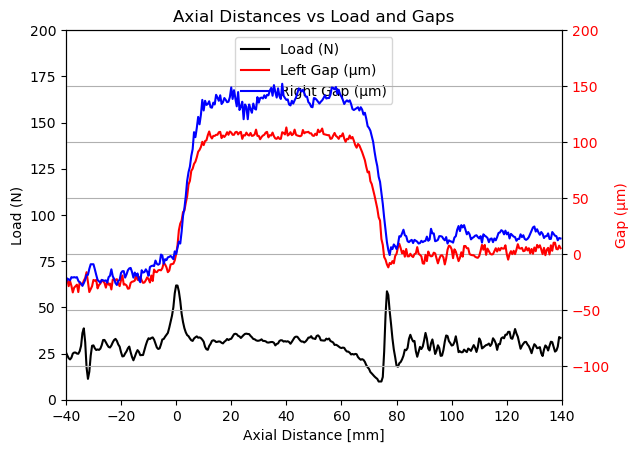

In [25]:
## Plot the data
# Load plot
fig, ax1 = plt.subplots()

load_plot = ax1.plot(x, load, color='black', label="Load (N)")
ax1.set_xlabel("Axial Distance [mm]")
ax1.set_ylabel("Load (N)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 200)

# Gap plots
ax2 = ax1.twinx() # Have the same x axis

left_gap_plot = ax2.plot(x, left_gap, color='red', label="Left Gap (μm)")
right_gap_plot = ax2.plot(x, right_gap, color='blue', label="Right Gap (μm)")
ax2.set_ylabel("Gap (μm)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# COmbinte the legends and output it
lines= load_plot + left_gap_plot + right_gap_plot
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper center")

plt.xlim(-40, 140)
plt.ylim(-130,200)
plt.title("Axial Distances vs Load and Gaps")
plt.grid()
plt.show()

In [26]:
mean_array = np.vstack([load, left_gap, right_gap])

mean_array = mean_array[:, start_idx:end_idx]
np.mean(mean_array, axis=(1))

array([ 32.47065939, 106.80224154, 138.92076262])

The first steady rising point starts at axial distance: -9.00 mm


C:\Users\gyang\AppData\Local\Temp\ipykernel_11504\2444102665.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')  # Handle NaN


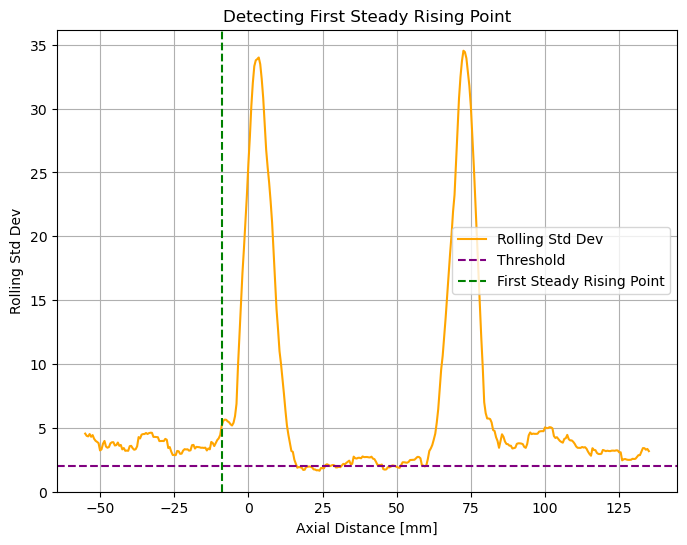

In [27]:
def find_first_rising_point(axial_distance, data, window_size=10, threshold=2, min_steady_points=5):
    """
    Detects the first steady rising point in the data based on rolling standard deviation.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze (e.g., left_gap, load, etc.).
        window_size (int): Window size for calculating the rolling standard deviation.
        threshold (float): Threshold for detecting the rise.
        min_steady_points (int): Minimum number of consecutive points above the threshold.

    Returns:
        float: Axial distance where the first steady rise starts (None if not found).
    """
    # Step 1: Calculate rolling standard deviation
    rolling_std = pd.Series(data).rolling(window=window_size, center=True).std()
    rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')  # Handle NaN

    # Step 2: Iterate sequentially to find the first steady rise
    count = 0  # Counter to track consecutive points above the threshold
    for i in range(len(rolling_std)):
        if rolling_std[i] > threshold:
            count += 1
            if count >= min_steady_points:
                return axial_distance[i - min_steady_points + 1]  # Return the start of the steady rise
        else:
            count = 0  # Reset if the threshold condition breaks

    print("No steady rising point detected.")
    return None

# Example usage
first_rising_point = find_first_rising_point(axial_distance, left_gap, window_size=20, threshold=5, min_steady_points=5)

if first_rising_point is not None:
    print(f"The first steady rising point starts at axial distance: {first_rising_point:.2f} mm")
    
    # Plot the rolling standard deviation for visualization
    plt.figure(figsize=(8, 6))
    rolling_std = pd.Series(left_gap).rolling(window=20, center=True).std()
    plt.plot(axial_distance, rolling_std, label="Rolling Std Dev", color='orange', linestyle='-')
    plt.axhline(y=2, color='purple', linestyle='--', label="Threshold")
    plt.axvline(x=first_rising_point, color='green', linestyle='--', label="First Steady Rising Point")
    
    plt.xlabel("Axial Distance [mm]")
    plt.ylabel("Rolling Std Dev")
    plt.title("Detecting First Steady Rising Point")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No significant steady rising point detected.")


In [28]:
x_data[13950]

6975.000000000001